In [ ]:
!pip install gsw netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00


In [ ]:
# ===== imports =====
import os, glob
import numpy as np
import xarray as xr
import pandas as pd
import gsw
from scipy.signal import argrelextrema as lmm
import scipy.signal as signal
import matplotlib.pyplot as plt

In [ ]:
# ===== small helpers =====
def safe_interp_1d(arr):
    """Linearly interpolate NaNs only if there are >=2 good points; otherwise return as-is."""
    out = np.asarray(arr, dtype=float).copy()
    nans = np.isnan(out)
    good = ~nans
    if good.sum() >= 2:
        idx = np.flatnonzero
        out[nans] = np.interp(idx(nans), idx(good), out[good])
    return out

def safe_filtfilt(B, A, arr):
    """Apply filtfilt only if data length is sufficient and finite; else return input."""
    a = np.asarray(arr, dtype=float)
    if np.all(np.isfinite(a)) and a.size > 6:  # N=1 butter requires padlen safety
        try:
            return signal.filtfilt(B, A, a, method="pad")
        except Exception:
            return a
    return a

def pick_var(ds, base):
    """Prefer *_ADJUSTED if present, else base."""
    adj = base + "_ADJUSTED"
    return ds[adj] if adj in ds.variables else ds[base]

def good_qc_mask(ds, base, qc_ok=("1","2")):
    """Return boolean mask where QC is in qc_ok (e.g., '1','2')."""
    qname = base + "_ADJUSTED_QC" if base + "_ADJUSTED_QC" in ds.variables else base + "_QC"
    if qname not in ds.variables:
        return None
    qc = ds[qname].astype("U1")
    return qc.isin(list(qc_ok))

def get_time_index(ds):
    """Robust Pandas DatetimeIndex from CF TIME."""
    dsd = xr.decode_cf(ds)
    t = dsd["TIME"]
    ti = t.to_index() if hasattr(t, "to_index") else pd.to_datetime(t.values)
    if hasattr(ti, "to_datetimeindex"):
        return ti.to_datetimeindex()
    return pd.DatetimeIndex(ti)

def gi_fallback_from_increase(chls):
    """
    Fallback GI pick:
      - interpolate if possible
      - simple 3-pt moving average
      - pick first index where we see two consecutive positive increments
        AND value >= (min + 0.5*std) threshold (if std available)
      - else first positive increment
    Returns global index 'i' or None.
    """
    a = np.asarray(chls, float)
    if np.isfinite(a).sum() < 5:
        return None
    a = safe_interp_1d(a)
    # simple moving average (3)
    if len(a) >= 3:
        kernel = np.ones(3)/3.0
        a_sm = np.convolve(a, kernel, mode="same")
    else:
        a_sm = a.copy()
    d = np.diff(a_sm)
    # threshold
    finite = np.isfinite(a_sm)
    if finite.sum() >= 2:
        std = np.nanstd(a_sm)
        amin = np.nanmin(a_sm)
        thresh = amin + 0.5*std if np.isfinite(std) else amin
    else:
        thresh = np.nanmin(a_sm[finite]) if finite.any() else 0.0
    # two-step rise crossing threshold
    for i in range(len(d)-1):
        if d[i] > 0 and d[i+1] > 0 and a_sm[i+1] >= thresh:
            return i+1
    # single positive step fallback
    for i in range(len(d)):
        if d[i] > 0:
            return i+1
    return None

In [ ]:
# ===== main detector (diagnostics-capable) =====
def save_meltbloom2(
    rtc=0.5,                    # T - T_freeze <= rtc marks under-ice
    bl=0,                       # extra levels below MLD for CHL mean
    DIR="",
    qc_ok=("0","1","2","8"),    # relaxed for optics
    gi_only_if_no_ice=True,
    debug=True,
    chl_gate_depth_m=100.0,     # prefer CHL within 0–100 m
    deep_gate_depth_m=200.0,    # fallback up to 200 m (logged)
    collect_diag=True
):
    def find_nearest(array, value):
        idx = np.nanargmin(np.abs(array - value))
        return int(idx)

    def frac_finite(arr):
        arr = np.asarray(arr)
        return 100.0 * np.isfinite(arr).sum() / arr.size if arr.size else 0.0

    flist = glob.glob(os.path.join(DIR, "*.nc"))
    print("No. of files:", len(flist))

    # aggregated outputs
    bloomdays  = np.array([]); bloomweeks = np.array([]); bloomweeks_m = np.array([])
    bloomyears = np.array([]); meltweeks  = np.array([]); meltdays     = np.array([])
    lons = np.array([]); lats = np.array([]); files = np.array([]); mld_gi = np.array([])
    mld_chl_pos = np.array([]); timing_pg = np.array([]); grth_rate_gm = np.array([])
    peak_chl = np.array([]); len_ts = np.array([]); melt_week = np.array([]); chl_sog = np.array([])
    gia_week = np.array([])

    # diagnostics container
    diag = {}

    # filters
    N = 1; Wn, Wn2 = 0.1, 0.2
    B, A  = signal.butter(N, Wn,  output="ba")
    B2, A2 = signal.butter(N, Wn2, output="ba")

    for f, path in enumerate(flist):
        print(f"\n=== File {f} { os.path.basename(path) } ===")
        ds = xr.open_dataset(path)

        # coords + variables
        if not all(v in ds.variables for v in ("TIME","LONGITUDE","LATITUDE")):
            print("  STOP: missing TIME/LONGITUDE/LATITUDE")
            ds.close(); continue
        t  = pick_var(ds, "TEMP")
        s  = pick_var(ds, "PSAL")
        pr = pick_var(ds, "PRES")
        if ("CPHL" in ds.variables) or ("CPHL_ADJUSTED" in ds.variables):
            chl = pick_var(ds, "CPHL")
        else:
            print("  STOP: no CPHL/CPHL_ADJUSTED")
            ds.close(); continue
        lon = ds["LONGITUDE"]
        lat = ds["LATITUDE"]

        time = get_time_index(ds)

        lon_dim = lon.dims[0]
        lat_dim = lat.dims[0]

        if "TIME" not in t.sizes:
            print("  STOP: TEMP has no TIME dim")
            ds.close(); continue
        nprof = int(t.sizes["TIME"])
        if lon.sizes[lon_dim] != nprof or lat.sizes[lat_dim] != nprof:
            print(f"  STOP: lon/lat length mismatch vs TIME ({lon.sizes[lon_dim]}/{lat.sizes[lat_dim]} vs {nprof})")
            ds.close(); continue

        # QC + screens
        for da, base in [(t,"TEMP"),(s,"PSAL"),(pr,"PRES"),(chl,"CPHL")]:
            m = good_qc_mask(ds, base, qc_ok=qc_ok)
            if m is not None and da.dims == m.dims:
                da[:] = da.where(m)
        s   = s.where(s > 28.0)
        chl = chl.where(chl >= 0)

        # timing diagnostics
        if nprof >= 2:
            step_days = np.diff(time.values) / np.timedelta64(1,"D")
            tsmax = float(np.nanmax(step_days)) if len(step_days) else np.nan
            span_days = float((time[-1] - time[0]).days)
        else:
            tsmax = np.nan; span_days = np.nan
        print(f"  profiles: {nprof}, time span days: {span_days:.1f}, max gap days: {tsmax if np.isfinite(tsmax) else np.nan:.1f}")
        print(f"  finite% (after QC/screens): TEMP {frac_finite(t.values):.1f}  PSAL {frac_finite(s.values):.1f}  PRES {frac_finite(pr.values):.1f}  CPHL {frac_finite(chl.values):.1f}")

        long_enough = (
            (np.isfinite(tsmax) and tsmax > 20 and nprof > 48) or
            (np.isfinite(tsmax) and tsmax <= 20 and nprof >= 24)
        )
        if not long_enough:
            print("  STOP: record too short or too gappy for seasonal analysis")
            ds.close(); continue

        # series we build
        rl = [None] * nprof
        pi = np.zeros(nprof)
        ts = np.array([]); ss = np.array([]); chls = np.array([]); mlds = np.array([])
        tdiff_series = []      # near-sfc T - Tf
        tns_series   = []      # near-sfc Temp (averaged)
        sns_series   = []      # near-sfc Salinity (averaged)
        tf_ns_series = []      # near-sfc freezing temp at i0

        # CHL gate counters
        used_shallow = used_deep = no_chl = 0

        for p in range(nprof):
            lonp = float(lon.isel({lon_dim: p}).values)
            latp = float(lat.isel({lat_dim: p}).values)
            pp   = np.asarray(pr.isel(TIME=p).values, dtype=float)
            chlp = np.asarray(chl.isel(TIME=p).values, dtype=float)

            dp = gsw.z_from_p(pp, latp); zpos = -dp  # +depth (m)
            if np.isnan(np.nanmean(dp)):
                dp = gsw.z_from_p(pp, float(lat.mean().values)); zpos = -dp

            tp = np.asarray(t.isel(TIME=p).values, dtype=float)
            sp = np.asarray(s.isel(TIME=p).values, dtype=float)
            spa = gsw.SA_from_SP(sp, pp, lonp, latp)
            if np.isnan(np.nanmean(spa)):
                spa = gsw.SA_from_SP(sp, pp, float(lon.mean().values), float(lat.mean().values))
            ct = gsw.CT_from_t(spa, tp, pp)
            n2, pmid = gsw.Nsquared(spa, ct, pp)
            dmid = gsw.z_from_p(pmid, latp)
            if np.isnan(np.nanmean(dmid)):
                dmid = gsw.z_from_p(pmid, float(lat.mean().values))

            # freezing temp (air-free) on the pressure grid; use near-sfc index
            tfreeze = gsw.t_freezing(spa, 0.0, 0.0)  # p=0 dbar
            try:
                i0 = int(np.nanargmin(pp))
            except Exception:
                i0 = 0

            try:
                mld = dmid[int(np.nanargmax(n2))]
                mlds = np.append(mlds, mld)

                # near-sfc 10 dbar window, fallback 20 dbar by pressure difference
                ddl = dp[i0] - 10.0
                ddi = int(np.nanargmin(np.abs(dp - ddl)))
                lo = min(ddi, i0); hi = max(ddi, i0) + 1
                seg = slice(lo, hi)
                vT = np.nanmean(tp[seg]); vS = np.nanmean(sp[seg])
                if np.isnan(vT) or np.isnan(vS):
                    p0 = pp[i0]; near_idx = np.where((pp - p0) <= 20.0)[0]
                    if near_idx.size:
                        if np.isnan(vT): vT = np.nanmean(tp[near_idx])
                        if np.isnan(vS): vS = np.nanmean(sp[near_idx])
                ts = np.append(ts, vT); ss = np.append(ss, vS)
                tns_series.append(vT); sns_series.append(vS)

                # CHL around MLD with relaxed gate
                valid_idx = np.where(~np.isnan(chlp))[0]
                if valid_idx.size == 0:
                    chls = np.append(chls, np.nan); no_chl += 1
                else:
                    shallow_idx = valid_idx[zpos[valid_idx] <= chl_gate_depth_m]
                    if shallow_idx.size > 0:
                        ic = int(shallow_idx.max()); used_shallow += 1
                    else:
                        deep_idx = valid_idx[zpos[valid_idx] <= deep_gate_depth_m]
                        ic = int((deep_idx if deep_idx.size else valid_idx).max()); used_deep += 1
                    ddic = int(np.nanargmin(np.abs(dp - mld)))
                    start = max(0, min(ddic - bl, ic)); stop = min(len(chlp), max(ddic - bl, ic) + 1)
                    vC = np.nanmean(chlp[start:stop])
                    chls = np.append(chls, vC)
            except Exception:
                mlds = np.append(mlds, np.nan); ts = np.append(ts, np.nan); ss = np.append(ss, np.nan); chls = np.append(chls, np.nan)
                tns_series.append(np.nan); sns_series.append(np.nan)

            # near-sfc freezing temp and T-Tf at i0
            try:
                tf_ns = float(tfreeze[i0])
            except Exception:
                tf_ns = np.nan
            tf_ns_series.append(tf_ns)
            try:
                tdiff = float(vT - tf_ns)
            except Exception:
                tdiff = np.inf
            tdiff_series.append(tdiff)

            # under-ice flag
            if np.isfinite(tdiff) and (tdiff <= rtc):
                rl[p] = 1; pi[p] = 1
            else:
                rl[p] = 0

        # seasonal axes
        week = pd.Index(time).isocalendar().week.to_numpy()
        day  = pd.Index(time).dayofyear.to_numpy()
        year = pd.Index(time).year.to_numpy()
        week = np.where(week <= 13, week + 52, week)
        day  = np.where(day  <= 89,  day  + 365, day)

        # prints
        def _ff(x): return f"{frac_finite(x):.1f}"
        print(f"  built series len: ts={len(ts)} ss={len(ss)} chl={len(chls)}  finite% ts:{_ff(ts)} ss:{_ff(ss)} chl:{_ff(chls)}")
        print(f"  CHL gating counts: shallow<= {int(chl_gate_depth_m)}m: {used_shallow}  deeper<= {int(deep_gate_depth_m)}m: {used_deep}  no-CHL: {no_chl}")
        if used_deep > 0 and used_shallow == 0:
            print(f"  INFO: No shallow (≤{int(chl_gate_depth_m)} m) CHL in this file; used deeper CHL up to {int(deep_gate_depth_m)} m where available.")
        elif used_deep > 0:
            print(f"  INFO: Some profiles lacked shallow CHL; used deeper CHL up to {int(deep_gate_depth_m)} m for {used_deep} profiles.")

        # safe interp + filters
        ts_i = safe_interp_1d(ts)
        ss_i = safe_interp_1d(ss)
        chls_i = safe_interp_1d(chls)
        chlsf = safe_filtfilt(B, A, chls_i); tsf = safe_filtfilt(B, A, ts_i); ssf = safe_filtfilt(B, A, ss_i)
        ssf2 = safe_filtfilt(B2, A2, ss_i)

        # ===== melt onset =====
        mis = np.array([], dtype=int)
        uice_ct = int(np.sum(pi == 1))
        print(f"  under-ice profiles (T-Tf <= {rtc}): {uice_ct}")
        tv = np.asarray([x for x in tdiff_series if np.isfinite(x)])
        if tv.size:
            q = np.nanpercentile(tv, [0,25,50,75,100])
            print(f"  T-Tf stats (°C): min:{q[0]:.3f} Q1:{q[1]:.3f} med:{q[2]:.3f} Q3:{q[3]:.3f} max:{q[4]:.3f}")
        if uice_ct >= 3:
            dpi = pi[1:] - pi[0:-1]
            mi  = np.where(dpi == -1)[0]
            print(f"  melt candidates (under-ice→open): {len(mi)}")
            keep = []
            for idx in mi:
                nundi = int(np.sum(pi[max(0, idx - 15): idx] == 1))
                if nundi >= 2: keep.append(idx)
            mi = np.array(keep, dtype=int)
            print(f"   after '≥2 prior under-ice' check: {len(mi)}")
            if mi.size > 1:
                dmi = np.abs(mi[1:] - mi[0:-1]); kept2 = 0
                for nm, melts in enumerate(mi):
                    salt = ssf2[melts:melts + 4]
                    dsalt = np.nanmean(salt[1:] - salt[0:-1])
                    cond = (nm < len(dmi) and dmi[nm] > 12 and dsalt < 0.0) or (nm == len(dmi) and dsalt < 0.0)
                    if cond:
                        mis = np.append(mis, melts); kept2 += 1
                print(f"   after salinity-drop & spacing check: {kept2}")
                if mis.size > 1:
                    mis = np.sort(mis.astype(int))
                    dmi_n = np.abs(mis[1:] - mis[0:-1])
                    mis = np.delete(mis, np.where(dmi_n < 12)[0])
            elif mi.size == 1:
                m0 = int(mi[0])
                salt = ssf2[m0:m0+4]
                dsalt = np.nanmean(salt[1:] - salt[0:-1])
                if dsalt < 0.0:
                    mis = np.append(mis, m0)
            print(f"  FINAL melt picks: {len(mis)}")
        else:
            print("  NOTE: fewer than 3 under-ice profiles → melt detection disabled")

        # ===== GI detection =====
        finite_chls = np.isfinite(chls_i)
        ch_std = np.nanstd(chls_i) if finite_chls.sum() >= 2 else 0.0
        chl_anom = chls_i - (ch_std if np.isfinite(ch_std) else 0.0)

        lmax = lmm(chlsf, np.greater)[0]
        lmin = lmm(chlsf, np.less)[0]
        print(f"  GI extrema counts: lmin={len(lmin)} lmax={len(lmax)}  finite% chl(after interp)={frac_finite(chls_i):.1f}")

        bloomday_f = np.array([]); bloomweek_f = np.array([]); bloomweek_m_f = np.array([])
        blm_inds = np.array([]); mld_a = np.array([]); mld_fg = np.array([]); pgweek = np.array([]); gia_a = np.array([])
        gi_found_segments = 0

        if len(lmin) > 0 and len(lmax) > 0:
            try:
                dlmin = len(chlsf) - lmin[-1]
            except IndexError:
                dlmin, lmin = lmax[0], np.array([0])
            try:
                dlmax = lmax[0]
            except IndexError:
                dlmax, lmax = len(chlsf)-1, np.array([len(chlsf)-1])

            nlmax, nlmin = len(lmax), len(lmin)
            if nlmin > nlmax and dlmin < 6: lmin = np.delete(lmin, -1)
            elif nlmin > nlmax and dlmin >= 6:
                chlsm = chls_i.copy(); chlsm[0:lmin[-1]] = np.nan
                lmaxe = np.nanargmax(chlsm); lmax = np.append(lmax, lmaxe)
            elif nlmin < nlmax and dlmax < 9: lmax = np.delete(lmax, 0)
            elif nlmin < nlmax and dlmax >= 9: lmin = np.concatenate(([0], lmin))
            elif nlmin == nlmax and dlmin >= 6:
                dlmm = lmax - lmin
                if np.sum(dlmm < 0) > 0:
                    chlsm = chls_i.copy(); chlsm[0:lmin[-1]] = np.nan
                    lmaxe = np.nanargmax(chlsm); lmax = np.append(lmax, lmaxe); lmax = np.delete(lmax, 0)
            elif nlmin == nlmax and dlmin < 6:
                lmax = np.delete(lmax, 0); lmin = np.delete(lmin, -1)

            for l in range(len(lmax)):
                imax, imin = int(lmax[l]), int(lmin[l])
                if (imin < imax) and (abs(imax - imin) > 3):
                    chlmm = chls_i[imin:imax]
                    peak_chl = np.append(peak_chl, np.nanmax(chlmm))
                    weekmm = week[imin:imax]; daymm = day[imin:imax]
                    dchl = chlmm[1:] - chlmm[0:-1]
                    dchl = np.where(dchl > 0.0, dchl, np.nan)
                    medchl = np.nanmedian(dchl)
                    blmind = int(np.nanargmax(dchl > medchl))
                    blmind_m = int(np.nanargmax(dchl))
                    chl_fi = int(np.nanargmax(dchl > 0.0))

                    blm_inds = np.append(blm_inds, imin + blmind)
                    bloomweek_f = np.append(bloomweek_f, weekmm[blmind])
                    bloomweek_m_f = np.append(bloomweek_m_f, weekmm[blmind_m])
                    bloomday_f  = np.append(bloomday_f,  daymm[blmind])

                    mldmm = mlds[imin:imax]
                    mld_a = np.append(mld_a, mldmm[blmind])
                    mld_fg = np.append(mld_fg, mldmm[chl_fi])
                    pgweek = np.append(pgweek, weekmm[chl_fi])

                    # alt anomaly pick, saved per-segment
                    try:
                        gia_a = np.append(gia_a, weekmm[np.min(np.where(chl_anom[imin:imax] > 0))])
                    except ValueError:
                        gia_a = np.append(gia_a, np.nan)

                    gi_found_segments += 1

        used_fallback = False
        if gi_found_segments == 0:
            gi_idx = gi_fallback_from_increase(chls_i)
            used_fallback = gi_idx is not None
            print(f"  GI fallback used: {used_fallback}  idx:{gi_idx if gi_idx is not None else 'None'}")
            if gi_idx is not None:
                bloomday_f   = np.append(bloomday_f,  day[gi_idx])
                bloomweek_f  = np.append(bloomweek_f, week[gi_idx])
                bloomweek_m_f = np.append(bloomweek_m_f, week[gi_idx])
                if len(mlds) > gi_idx: mld_a = np.append(mld_a, mlds[gi_idx])
                else:                   mld_a = np.append(mld_a, np.nan)
                pgweek = np.append(pgweek, week[gi_idx])
                blm_inds = np.append(blm_inds, gi_idx)
                gia_week = np.append(gia_week, week[gi_idx])
        print(f"  GI picks: {len(bloomweek_f)}  (segments:{gi_found_segments}, fallback:{used_fallback})")

        # ===== pairing & export =====
        if (mis.size == 0) and gi_only_if_no_ice and (len(bloomweek_f) > 0):
            print("  Exporting GI-only rows (no melt detected)")
            for e in range(len(bloomweek_f)):
                bloomdays  = np.append(bloomdays,  bloomday_f[e])
                bloomweeks = np.append(bloomweeks, bloomweek_f[e])
                bloomweeks_m = np.append(bloomweeks_m, bloomweek_m_f[e])
                bloomyears = np.append(bloomyears, year[0])  # coarse; same-year assumption per segment
                meltweeks  = np.append(meltweeks, np.nan)
                meltdays   = np.append(meltdays,  np.nan)
                lons       = np.append(lons, float(lon.isel({lon_dim: int(blm_inds[e])}).values))
                lats       = np.append(lats, float(lat.isel({lat_dim: int(blm_inds[e])}).values))
                files      = np.append(files, f)
                mld_gi     = np.append(mld_gi, mld_a[e])
                mld_chl_pos = np.append(mld_chl_pos, np.nan)
                timing_pg  = np.append(timing_pg, pgweek[e] if len(pgweek) > e else np.nan)
        else:
            meltday = np.array([day[m] for m in mis.astype(int)])
            pair_ct = 0
            for e in range(min(mis.size, len(bloomday_f))):
                if abs(float(meltday[e]) - float(bloomday_f[e])) <= 90:
                    pair_ct += 1
            print(f"  Potential GI–melt pairs within 90 days: {pair_ct}")

            for e in range(min(len(meltday), len(bloomday_f))):
                dd = abs(meltday[e] - bloomday_f[e])
                if dd <= 90:
                    bloomdays  = np.append(bloomdays,  bloomday_f[e])
                    bloomweeks = np.append(bloomweeks, bloomweek_f[e])
                    bloomweeks_m = np.append(bloomweeks_m, bloomweek_m_f[e])
                    bloomyears = np.append(bloomyears, year[0])
                    meltweeks  = np.append(meltweeks,  int(np.array([week[m] for m in mis.astype(int)])[e]))
                    meltdays   = np.append(meltdays,   meltday[e])
                    idx_for_loc = int(blm_inds[e])
                    lons = np.append(lons, float(lon.isel({lon_dim: idx_for_loc}).values))
                    lats = np.append(lats, float(lat.isel({lat_dim: idx_for_loc}).values))
                    files = np.append(files, f)
                    mld_gi = np.append(mld_gi, mld_a[e])
                    mld_chl_pos = np.append(mld_chl_pos, np.nan)
                    timing_pg   = np.append(timing_pg,   pgweek[e] if e < len(pgweek) else np.nan)

        len_ts = np.append(len_ts, len(chls_i))

        # ---- collect diagnostics per file ----
        if collect_diag:
            diag[f] = {
                "path": path,
                "time": time,
                "week": week, "day": day, "year": year,
                "lon": lon.values.astype(float),
                "lat": lat.values.astype(float),
                "ts_raw": ts, "ss_raw": ss, "chl_raw": chls,
                "ts_f": tsf, "ss_f": ssf, "chl_f": chlsf,
                "mld": mlds,                 # negative depth (m)
                "pi": pi.astype(int),        # under-ice flag
                "tdiff": np.asarray(tdiff_series, float),
                "tf_ns": np.asarray(tf_ns_series, float),
                "melt_idx": np.asarray(mis, int),
                "gi_idx": np.asarray(blm_inds, int) if len(blm_inds) else np.array([], dtype=int),
                "notes": {
                    "used_shallow": int(used_shallow),
                    "used_deep": int(used_deep),
                    "no_chl": int(no_chl),
                    "rtc": float(rtc),
                    "chl_gate_depth_m": float(chl_gate_depth_m),
                    "deep_gate_depth_m": float(deep_gate_depth_m),
                }
            }

        ds.close()

    # ---- summary prints ----
    print("\n=== Summary across files ===")
    print("Avg. length of time series:", np.nanmean(len_ts) if len(len_ts) else np.nan)
    print("Avg. peak chlorophyll:",     np.nanmean(peak_chl) if len(peak_chl) else np.nan)
    print("Avg. melt week:",            np.nanmean(melt_week) if len(melt_week) else np.nan)
    print("Avg. chla at GI:",           np.nanmean(chl_sog) if len(chl_sog) else np.nan)
    print("Avg. MLD at GI:",            np.nanmean(mld_gi) if len(mld_gi) else np.nan)
    print("Avg. Growth Rate GI->Melt:", np.nanmean(grth_rate_gm) if len(grth_rate_gm) else np.nan)
    print("Avg. Timing of First Positive Chl:", np.nanmean(timing_pg) if len(timing_pg) else np.nan)
    print("Avg. MLD at First Positive Chl:",    np.nanmean(mld_chl_pos) if len(mld_chl_pos) else np.nan)

    return (
        bloomweeks, bloomdays, bloomweeks_m, bloomyears,
        meltweeks, meltdays, lons, lats, files, mld_gi, gia_week, diag
    )

# ===== convenience: pad vectors to same length =====
def _pad_to_len(a, L):
    a = np.asarray(a)
    n = a.size
    if n == L: return a
    if n > L:  return a[:L]
    pad = np.full(L - n, np.nan)
    return np.concatenate([a, pad])

In [ ]:
# ===== run detector + write out.nc =====
DIR = "/content/Floats"  #"/glade/u/home/vyaasv/Floats"/content/GL_PR_PF_5904183.nc

(bloomweeks, bloomdays, bloomweeks_m, bloomyears,
 meltweeks, meltdays, lons, lats, files, mld_gi, gia_week, diag) = save_meltbloom2(
    rtc=0.3,
    bl=0,
    DIR=DIR,
    qc_ok=("0","1","2","8"),
    gi_only_if_no_ice=True,
    debug=True,
    chl_gate_depth_m=100.0,
    deep_gate_depth_m=200.0,
    collect_diag=True
)

all_arrays = {
    "bloomweeks":     bloomweeks,
    "bloomdays":      bloomdays,
    "bloomweeks_max": bloomweeks_m,
    "bloomyears":     bloomyears,
    "meltweeks":      meltweeks,
    "meltdays":       meltdays,
    "mld_gi":         mld_gi,
    "lons":           lons,
    "lats":           lats,
    "files":          files,     # becomes float if padded with NaN; OK
    "gia_week":       gia_week,  # may be shorter; will be padded
}
L = max(len(v) for v in all_arrays.values()) if all_arrays else 0
all_arrays = {k: _pad_to_len(v, L) for k, v in all_arrays.items()}

dsb = xr.Dataset({k: (["e"], v) for k, v in all_arrays.items()})
out_path = os.path.join(DIR, "out.nc")
dsb.to_netcdf(out_path, format="NETCDF4_CLASSIC")
print("Wrote:", out_path)

No. of files: 14

=== File 0 GL_PR_PF_5905993.nc ===
  profiles: 49, time span days: 1460.0, max gap days: 968.7
  finite% (after QC/screens): TEMP 95.3  PSAL 93.3  PRES 95.5  CPHL 7.2


/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):


  built series len: ts=49 ss=49 chl=49  finite% ts:98.0 ss:98.0 chl:95.9
  CHL gating counts: shallow<= 100m: 45  deeper<= 200m: 2  no-CHL: 1
  INFO: Some profiles lacked shallow CHL; used deeper CHL up to 200 m for 2 profiles.
  under-ice profiles (T-Tf <= 0.3): 39
  T-Tf stats (°C): min:-0.029 Q1:-0.001 med:0.030 Q3:0.112 max:2.128
  melt candidates (under-ice→open): 2
   after '≥2 prior under-ice' check: 2
   after salinity-drop & spacing check: 1
  FINAL melt picks: 1
  GI extrema counts: lmin=2 lmax=2  finite% chl(after interp)=100.0
  GI picks: 1  (segments:1, fallback:False)
  Potential GI–melt pairs within 90 days: 1

=== File 1 GL_PR_PF_5905995.nc ===
  profiles: 192, time span days: 1916.0, max gap days: 10.2
  finite% (after QC/screens): TEMP 98.7  PSAL 98.7  PRES 98.9  CPHL 11.1


/tmp/ipython-input-958809243.py:147: RuntimeWarning: Mean of empty slice
  vT = np.nanmean(tp[seg]); vS = np.nanmean(sp[seg])


  built series len: ts=192 ss=192 chl=192  finite% ts:100.0 ss:100.0 chl:100.0
  CHL gating counts: shallow<= 100m: 190  deeper<= 200m: 2  no-CHL: 0
  INFO: Some profiles lacked shallow CHL; used deeper CHL up to 200 m for 2 profiles.
  under-ice profiles (T-Tf <= 0.3): 119
  T-Tf stats (°C): min:0.004 Q1:0.042 med:0.084 Q3:0.915 max:2.713
  melt candidates (under-ice→open): 6
   after '≥2 prior under-ice' check: 6
   after salinity-drop & spacing check: 5
  FINAL melt picks: 5
  GI extrema counts: lmin=5 lmax=5  finite% chl(after interp)=100.0
  GI picks: 5  (segments:5, fallback:False)
  Potential GI–melt pairs within 90 days: 5

=== File 2 GL_PR_PF_5905994.nc ===
  profiles: 192, time span days: 1916.0, max gap days: 10.5
  finite% (after QC/screens): TEMP 98.5  PSAL 98.5  PRES 98.7  CPHL 10.5
  built series len: ts=192 ss=192 chl=192  finite% ts:100.0 ss:100.0 chl:100.0
  CHL gating counts: shallow<= 100m: 178  deeper<= 200m: 14  no-CHL: 0
  INFO: Some profiles lacked shallow CHL; 

/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:147: RuntimeWarning: Mean of empty slice
  vT = np.nanmean(tp[seg]); vS = np.nanmean(sp[seg])
/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:12

  built series len: ts=119 ss=119 chl=119  finite% ts:69.7 ss:69.7 chl:68.1
  CHL gating counts: shallow<= 100m: 81  deeper<= 200m: 0  no-CHL: 2
  under-ice profiles (T-Tf <= 0.3): 28
  T-Tf stats (°C): min:0.005 Q1:0.032 med:0.042 Q3:0.054 max:0.179
  melt candidates (under-ice→open): 13
   after '≥2 prior under-ice' check: 13
   after salinity-drop & spacing check: 2
  FINAL melt picks: 2
  GI extrema counts: lmin=2 lmax=2  finite% chl(after interp)=100.0
  GI picks: 2  (segments:2, fallback:False)
  Potential GI–melt pairs within 90 days: 1

=== File 4 GL_PR_PF_5905991.nc ===
  profiles: 58, time span days: 1072.0, max gap days: 512.2
  finite% (after QC/screens): TEMP 98.5  PSAL 98.5  PRES 98.7  CPHL 11.2
  built series len: ts=58 ss=58 chl=58  finite% ts:100.0 ss:100.0 chl:100.0
  CHL gating counts: shallow<= 100m: 57  deeper<= 200m: 1  no-CHL: 0
  INFO: Some profiles lacked shallow CHL; used deeper CHL up to 200 m for 1 profiles.
  under-ice profiles (T-Tf <= 0.3): 32
  T-Tf stat

/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):


  built series len: ts=106 ss=106 chl=106  finite% ts:99.1 ss:99.1 chl:99.1
  CHL gating counts: shallow<= 100m: 96  deeper<= 200m: 9  no-CHL: 0
  INFO: Some profiles lacked shallow CHL; used deeper CHL up to 200 m for 9 profiles.
  under-ice profiles (T-Tf <= 0.3): 65
  T-Tf stats (°C): min:0.002 Q1:0.022 med:0.050 Q3:1.007 max:2.106
  melt candidates (under-ice→open): 5
   after '≥2 prior under-ice' check: 5
   after salinity-drop & spacing check: 3
  FINAL melt picks: 3
  GI extrema counts: lmin=4 lmax=3  finite% chl(after interp)=100.0
  GI picks: 3  (segments:3, fallback:False)
  Potential GI–melt pairs within 90 days: 3

=== File 7 GL_PR_PF_5906494.nc ===
  profiles: 76, time span days: 1062.0, max gap days: 298.1
  finite% (after QC/screens): TEMP 98.8  PSAL 98.7  PRES 98.9  CPHL 11.1
  built series len: ts=76 ss=76 chl=76  finite% ts:100.0 ss:100.0 chl:98.7
  CHL gating counts: shallow<= 100m: 73  deeper<= 200m: 2  no-CHL: 1
  INFO: Some profiles lacked shallow CHL; used deeper

/tmp/ipython-input-958809243.py:147: RuntimeWarning: Mean of empty slice
  vT = np.nanmean(tp[seg]); vS = np.nanmean(sp[seg])
/tmp/ipython-input-958809243.py:152: RuntimeWarning: Mean of empty slice
  if np.isnan(vS): vS = np.nanmean(sp[near_idx])


  built series len: ts=41 ss=41 chl=41  finite% ts:100.0 ss:97.6 chl:100.0
  CHL gating counts: shallow<= 100m: 40  deeper<= 200m: 1  no-CHL: 0
  INFO: Some profiles lacked shallow CHL; used deeper CHL up to 200 m for 1 profiles.
  under-ice profiles (T-Tf <= 0.3): 23
  T-Tf stats (°C): min:0.027 Q1:0.051 med:0.102 Q3:2.180 max:4.124
  melt candidates (under-ice→open): 2
   after '≥2 prior under-ice' check: 2
   after salinity-drop & spacing check: 1
  FINAL melt picks: 1
  GI extrema counts: lmin=1 lmax=1  finite% chl(after interp)=100.0
  GI picks: 1  (segments:1, fallback:False)
  Potential GI–melt pairs within 90 days: 1

=== File 13 GL_PR_PF_5904183.nc ===
  profiles: 233, time span days: 2497.0, max gap days: 123.2
  finite% (after QC/screens): TEMP 98.6  PSAL 97.7  PRES 98.7  CPHL 10.6


/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):
/tmp/ipython-input-958809243.py:123: RuntimeWarning: Mean of empty slice
  if np.isnan(np.nanmean(spa)):


  built series len: ts=233 ss=233 chl=233  finite% ts:99.1 ss:99.1 chl:99.1
  CHL gating counts: shallow<= 100m: 222  deeper<= 200m: 9  no-CHL: 0
  INFO: Some profiles lacked shallow CHL; used deeper CHL up to 200 m for 9 profiles.
  under-ice profiles (T-Tf <= 0.3): 183
  T-Tf stats (°C): min:-0.003 Q1:0.027 med:0.057 Q3:0.206 max:1.931
  melt candidates (under-ice→open): 9
   after '≥2 prior under-ice' check: 9
   after salinity-drop & spacing check: 6
  FINAL melt picks: 6
  GI extrema counts: lmin=7 lmax=6  finite% chl(after interp)=100.0
  GI picks: 7  (segments:7, fallback:False)
  Potential GI–melt pairs within 90 days: 5

=== Summary across files ===
Avg. length of time series: 113.92307692307692
Avg. peak chlorophyll: 0.9083585237807756
Avg. melt week: nan
Avg. chla at GI: nan
Avg. MLD at GI: -145.0725082559522
Avg. Growth Rate GI->Melt: nan
Avg. Timing of First Positive Chl: 35.17142857142857
Avg. MLD at First Positive Chl: nan
Wrote: /content/Floats/out.nc


/tmp/ipython-input-958809243.py:420: RuntimeWarning: Mean of empty slice
  print("Avg. MLD at First Positive Chl:",    np.nanmean(mld_chl_pos) if len(mld_chl_pos) else np.nan)


In [ ]:
# ===== diagnostics helpers =====
def list_diag_summary(diag_dict):
    """Quick table of which floats have picks."""
    rows = []
    for f, d in diag_dict.items():
        rows.append((f, os.path.basename(d["path"]), len(d["gi_idx"]), len(d["melt_idx"]),
                     d["notes"]["used_shallow"], d["notes"]["used_deep"]))
    rows = sorted(rows, key=lambda x: x[0])
    print("f  |        file         | GI_picks | Melt_picks | CHL<=100m | CHL<=200m")
    for r in rows:
        print(f"{r[0]:2d} | {r[1]} | {r[2]:8d} | {r[3]:10d} | {r[4]:9d} | {r[5]:9d}")

In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.dates as mdates

def _proxy_lines():
    gi_proxy   = Line2D([0], [0], color="C3", lw=1.4, linestyle="-",  label="GI")
    melt_proxy = Line2D([0], [0], color="C3", lw=1.4, linestyle="--", label="Melt")
    return gi_proxy, melt_proxy

def _add_event_lines(ax, t, gi_idx, melt_idx, color="C3"):
    for i in gi_idx:
        if 0 <= i < len(t): ax.axvline(t[i], color=color, lw=1.2, ls="-")
    for i in melt_idx:
        if 0 <= i < len(t): ax.axvline(t[i], color=color, lw=1.2, ls="--")

def _apply_year_ticks(ax, label="Year"):
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.set_xlabel(label)

def plot_float_panels(diag_dict, f, title=None):
    """
    Make THREE SEPARATE FIGURES (not subplots), each with its own x-label:
      1) CHL (raw + filtered) with GI (solid) and Melt (dashed) markers
      2) Near-surface T and T_freeze, right axis T − Tf, under-ice shading
      3) Near-surface S (left) and |MLD| (right)
    """
    if f not in diag_dict:
        raise ValueError(f"float index {f} not found in diagnostics")

    d = diag_dict[f]
    t = pd.DatetimeIndex(d["time"])
    gi_idx  = np.asarray(d["gi_idx"], int)
    melt_idx = np.asarray(d["melt_idx"], int)
    rtc = float(d["notes"].get("rtc", 0.5))
    title_stub = title or f"{os.path.basename(d['path'])} (float #{f})"
    plt.rcParams.update({"figure.dpi": 130})

    # ---------- Fig 1: CHL ----------
    fig1 = plt.figure(figsize=(12, 4))
    ax1 = fig1.gca()
    l_chl_f, = ax1.plot(t, d["chl_f"], lw=1.4, label="CHL (filtered)")
    s_chl_r  = ax1.scatter(t, d["chl_raw"], s=12, alpha=0.7, label="CHL (raw)")
    _add_event_lines(ax1, t, gi_idx, melt_idx)
    gi_proxy, melt_proxy = _proxy_lines()

    ax1.set_ylabel("Chlorophyll (a.u.)")
    ax1.set_title(f"Mixed-layer CHL with GI (solid) and melt (dashed) — {title_stub}")
    ax1.grid(alpha=0.3)
    ax1.legend([l_chl_f, s_chl_r, gi_proxy, melt_proxy],
               [h.get_label() for h in [l_chl_f, s_chl_r, gi_proxy, melt_proxy]],
               loc="upper left")
    _apply_year_ticks(ax1)  # x-label on this figure
    fig1.tight_layout()
    plt.show()

    # ---------- Fig 2: Temperature / T_freeze with T − Tf and shading ----------
    fig2 = plt.figure(figsize=(12, 4))
    axT = fig2.gca()
    l_T,  = axT.plot(t, d["ts_f"], lw=1.4, label="T (near-sfc, filtered)")
    l_Tf, = axT.plot(t, d["tf_ns"], lw=1.2, label="T_freeze (near-sfc)")

    tdiff = np.asarray(d["tdiff"], float)
    under = np.where(np.isfinite(tdiff) & (tdiff <= rtc))[0]
    shade_handle = None
    if under.size > 0:
        for i in under:
            t0, t1 = t[i], t[min(i + 1, len(t) - 1)]
            axT.axvspan(t0, t1, alpha=0.15)
        shade_handle = Patch(alpha=0.15, label=f"Under-ice (T−Tf ≤ {rtc:g})")

    axTd = axT.twinx()
    l_dT, = axTd.plot(t, tdiff, lw=1.0, label="T − Tf")

    _add_event_lines(axT, t, gi_idx, melt_idx)

    axT.set_ylabel("Temperature (°C)")
    axTd.set_ylabel("T − Tf (°C)")
    axT.set_title(f"Near-surface T and freezing T with under-ice shading — {title_stub}")
    axT.grid(alpha=0.3)

    left_h, left_l   = axT.get_legend_handles_labels()
    right_h, right_l = axTd.get_legend_handles_labels()
    gi_proxy, melt_proxy = _proxy_lines()
    handles = left_h + right_h + [gi_proxy, melt_proxy]
    labels  = left_l + right_l + [gi_proxy.get_label(), melt_proxy.get_label()]
    if shade_handle is not None:
        handles.append(shade_handle); labels.append(shade_handle.get_label())
    axT.legend(handles, labels, loc="upper left")

    _apply_year_ticks(axT)  # x-label on this figure
    fig2.tight_layout()
    plt.show()

    # ---------- Fig 3: Salinity / |MLD| ----------
    fig3 = plt.figure(figsize=(12, 4))
    axS = fig3.gca()
    l_S,  = axS.plot(t, d["ss_f"], lw=1.4, label="S (near-sfc, filtered)")

    axM = axS.twinx()
    mld_mag = np.abs(np.asarray(d["mld"], float))
    l_MLD, = axM.plot(t, mld_mag, lw=1.0, label="MLD |depth|")

    _add_event_lines(axS, t, gi_idx, melt_idx)

    axS.set_ylabel("Salinity")
    axM.set_ylabel("MLD (m)")
    axS.set_title(f"Near-surface S with mixed-layer depth magnitude — {title_stub}")
    axS.grid(alpha=0.3)

    left_h, left_l   = axS.get_legend_handles_labels()
    right_h, right_l = axM.get_legend_handles_labels()
    gi_proxy, melt_proxy = _proxy_lines()
    axS.legend(left_h + right_h + [gi_proxy, melt_proxy],
               left_l + right_l + [gi_proxy.get_label(), melt_proxy.get_label()],
               loc="upper left")

    _apply_year_ticks(axS)  # x-label on this figure
    fig3.tight_layout()
    plt.show()

f  |        file         | GI_picks | Melt_picks | CHL<=100m | CHL<=200m
 0 | GL_PR_PF_5905993.nc |        1 |          1 |        45 |         2
 1 | GL_PR_PF_5905995.nc |        5 |          5 |       190 |         2
 2 | GL_PR_PF_5905994.nc |        5 |          5 |       178 |        14
 3 | GL_PR_PF_6904235.nc |        2 |          2 |        81 |         0
 4 | GL_PR_PF_5905991.nc |        2 |          2 |        57 |         1
 5 | GL_PR_PF_5906498.nc |        3 |          3 |        98 |         6
 6 | GL_PR_PF_5906499.nc |        3 |          3 |        96 |         9
 7 | GL_PR_PF_5906494.nc |        2 |          2 |        73 |         2
 9 | GL_PR_PF_5904397.nc |        2 |          1 |        50 |         0
10 | GL_PR_PF_5905992.nc |        3 |          3 |       113 |         4
11 | GL_PR_PF_5904472.nc |        4 |          4 |       143 |         1
12 | GL_PR_PF_5904467.nc |        1 |          1 |        40 |         1
13 | GL_PR_PF_5904183.nc |        7 |          6 | 

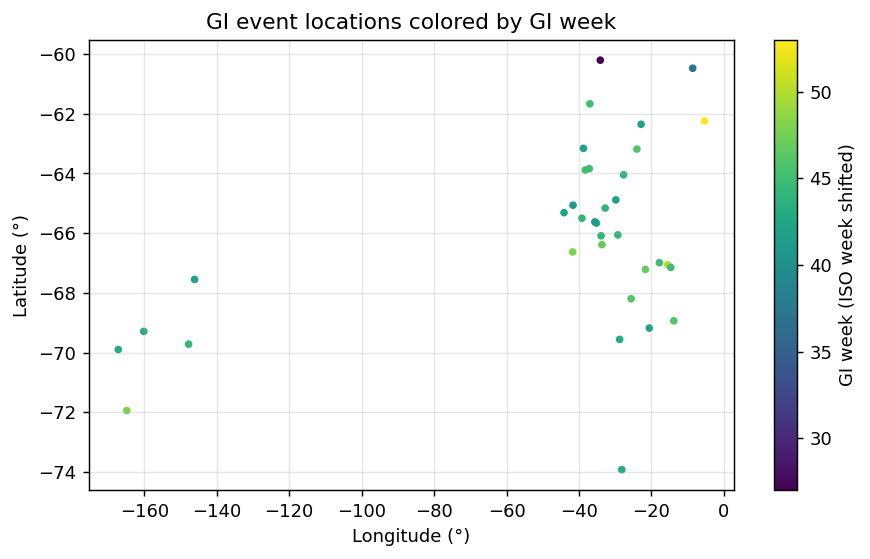



Fig B


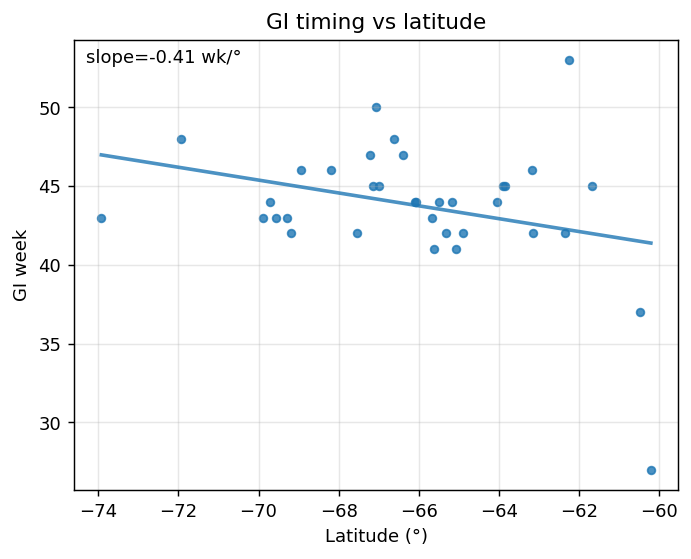



Fig C


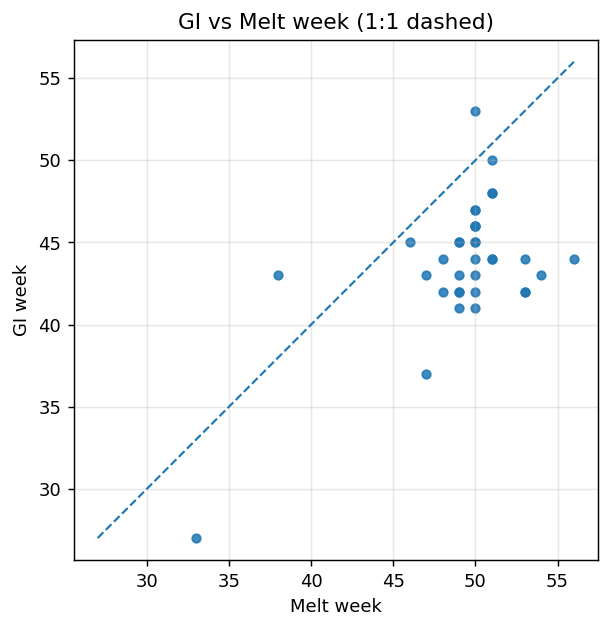



Fig D


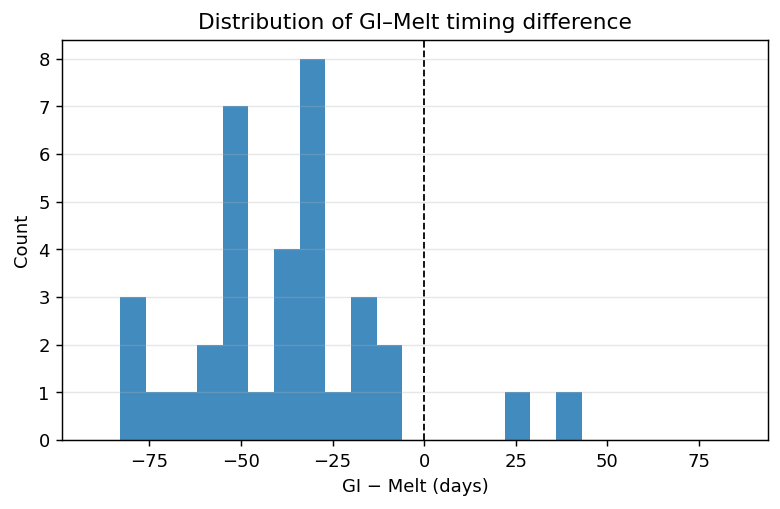



Fig E


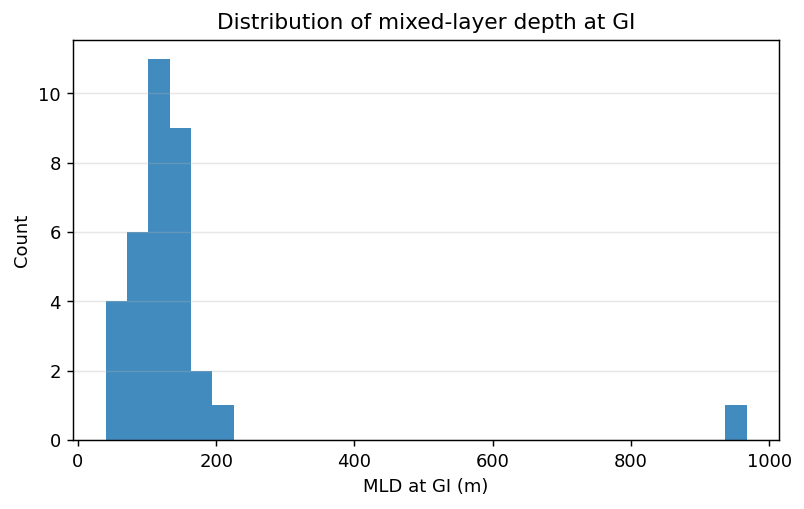

Plotting Fig F for float index 13: GL_PR_PF_5904183.nc


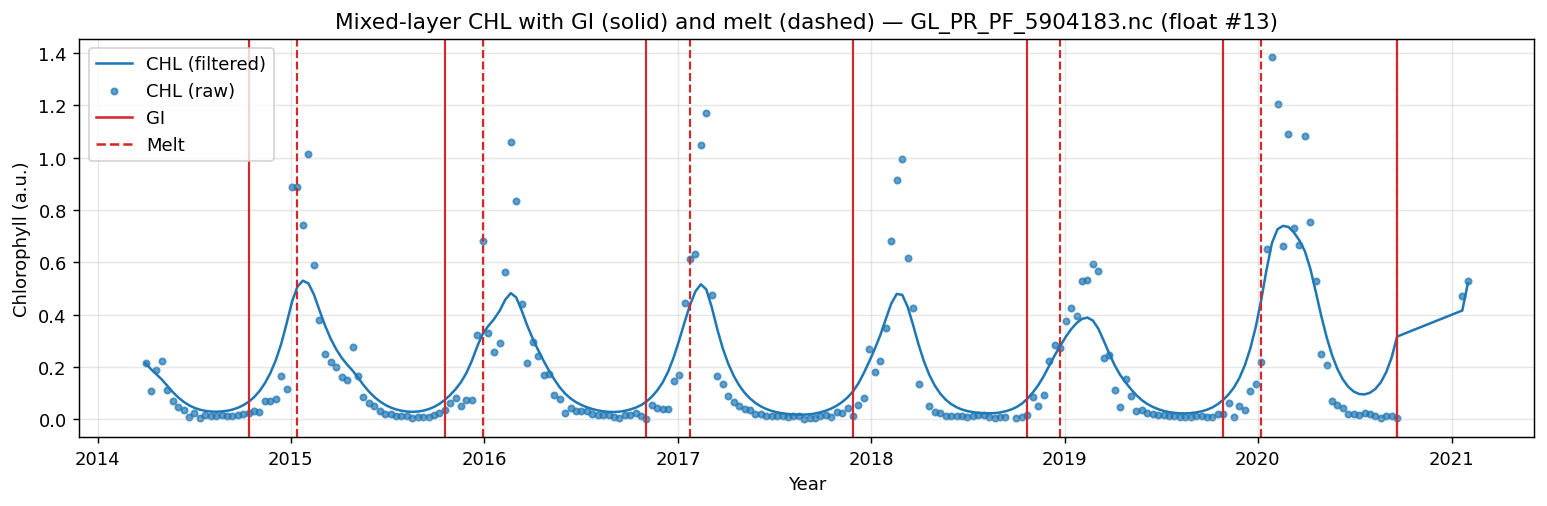

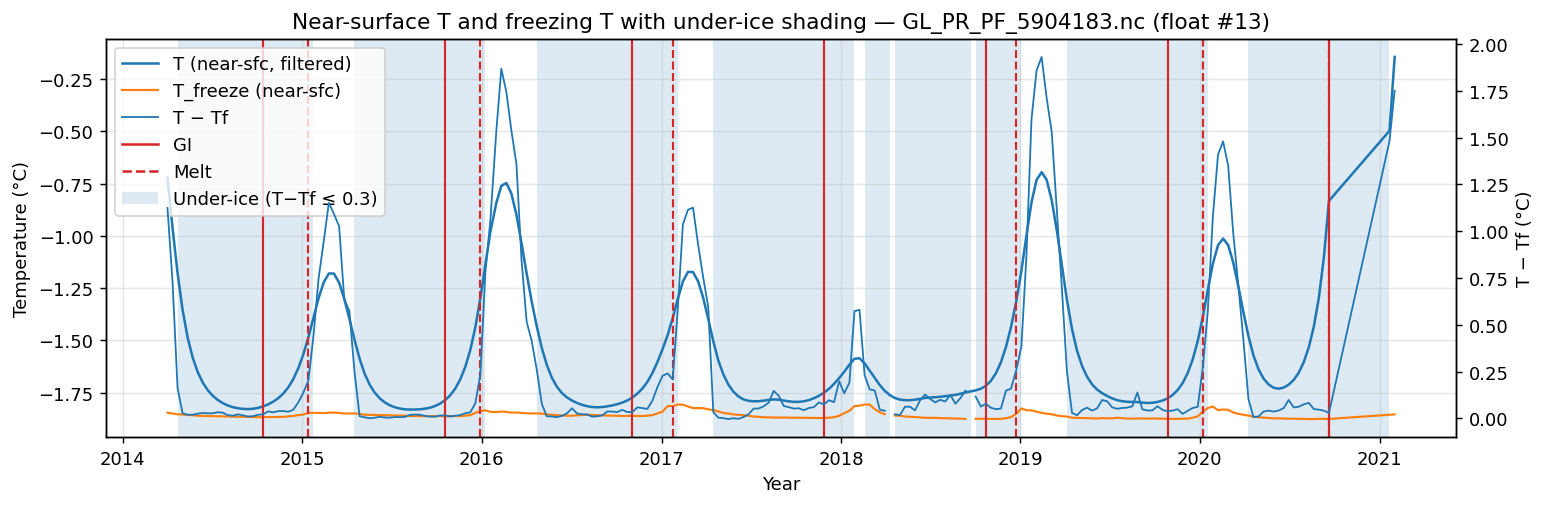

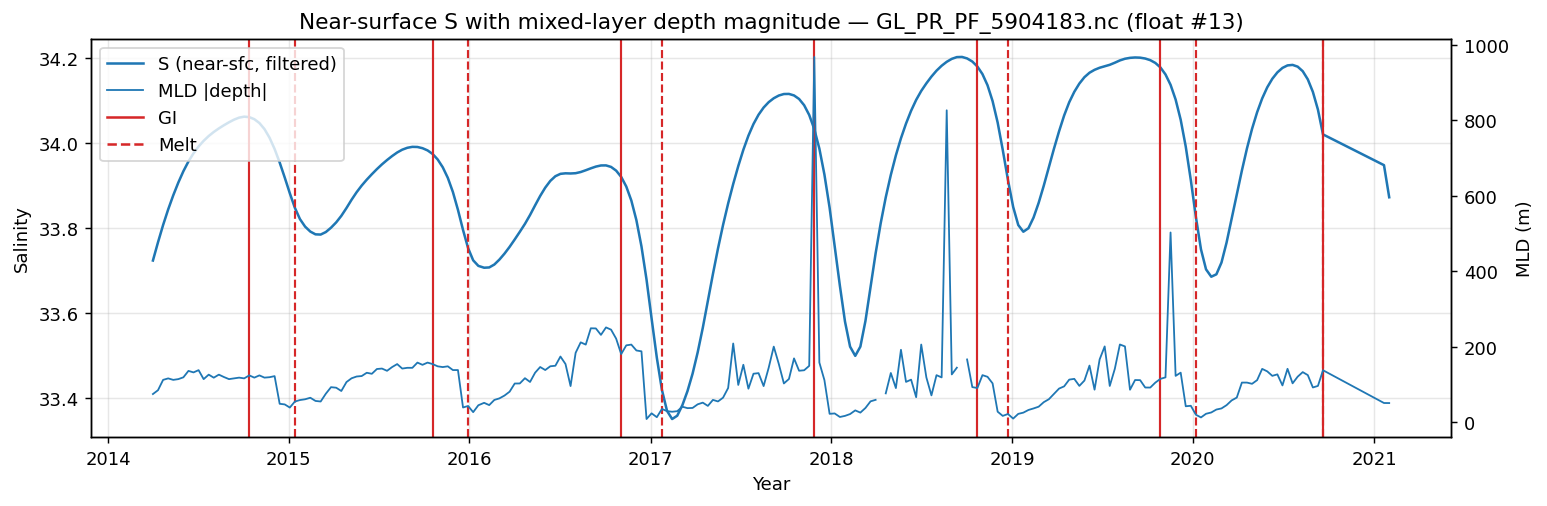

In [ ]:
# ===== quick plotting suite for out.nc =====
def _arr(ds, name):
    a = np.asarray(ds[name].values, float)
    return a

def _valid_mask(*arrays):
    m = np.ones_like(arrays[0], dtype=bool)
    for a in arrays:
        m &= np.isfinite(a)
    return m

def _to_lon180(lon):
    lon = lon.copy()
    lon = np.where(lon > 180, lon - 360, lon)
    lon = np.where(lon < -180, lon + 360, lon)
    return lon

# ----- run a quick summary + a few figures (A–E). Fig F uses diagnostics -----
list_diag_summary(diag)

OUT_PATH = os.path.join(DIR, "out.nc")
ds_out = xr.open_dataset(OUT_PATH)

bloomweeks = _arr(ds_out, "bloomweeks")
bloomdays  = _arr(ds_out, "bloomdays")
meltweeks  = _arr(ds_out, "meltweeks")
meltdays   = _arr(ds_out, "meltdays")
mld_gi     = _arr(ds_out, "mld_gi")
lons       = _arr(ds_out, "lons")
lats       = _arr(ds_out, "lats")

plt.rcParams.update({"figure.dpi": 130})

# Fig A — Map of GI locations colored by GI week
mA = _valid_mask(bloomweeks, lons, lats)
if np.any(mA):
    print("\n\nFig A")
    lon180 = _to_lon180(lons[mA])
    plt.figure(figsize=(8,4.5))
    sc = plt.scatter(lon180, lats[mA], c=bloomweeks[mA], s=18, cmap="viridis", edgecolor="none")
    plt.colorbar(sc, label="GI week (ISO week shifted)")
    plt.xlabel("Longitude (°)")
    plt.ylabel("Latitude (°)")
    plt.title("GI event locations colored by GI week")
    plt.grid(alpha=0.3)
    plt.show()
else:
    print("Fig A: No valid GI+location data to plot.")

# Fig B — GI week vs Latitude (with linear fit)
print("\n\nFig B")
mB = _valid_mask(bloomweeks, lats)
xB, yB = lats[mB], bloomweeks[mB]
plt.figure(figsize=(6,4.5))
plt.scatter(xB, yB, s=18, alpha=0.8)
if xB.size >= 2:
    p = np.polyfit(xB, yB, 1)
    xx = np.linspace(np.nanmin(xB), np.nanmax(xB), 100)
    yy = p[0]*xx + p[1]
    plt.plot(xx, yy, lw=2, alpha=0.8)
    plt.text(0.02, 0.98, f"slope={p[0]:.2f} wk/°", transform=plt.gca().transAxes,
             ha="left", va="top")
plt.xlabel("Latitude (°)")
plt.ylabel("GI week")
plt.title("GI timing vs latitude")
plt.grid(alpha=0.3)
plt.show()

# Fig C — GI week vs Melt week (1:1)
print("\n\nFig C")
mC = _valid_mask(bloomweeks, meltweeks)
xC, yC = meltweeks[mC], bloomweeks[mC]
plt.figure(figsize=(5.2,5.2))
plt.scatter(xC, yC, s=22, alpha=0.85)
if xC.size:
    mn = np.nanmin(np.concatenate([xC, yC]))
    mx = np.nanmax(np.concatenate([xC, yC]))
    plt.plot([mn, mx], [mn, mx], ls="--", lw=1.2)
plt.xlabel("Melt week")
plt.ylabel("GI week")
plt.title("GI vs Melt week (1:1 dashed)")
plt.grid(alpha=0.3)
plt.axis("equal")
plt.show()

# Fig D — Δt = GI − Melt (days) histogram
mD = _valid_mask(bloomdays, meltdays)
if np.any(mD):
    print("\n\nFig D")
    dd = bloomdays[mD] - meltdays[mD]
    plt.figure(figsize=(7,4))
    bins = np.arange(-90, 91, 7)  # weekly bins over ±90 days
    plt.hist(dd, bins=bins, alpha=0.85)
    plt.axvline(0, color="k", ls="--", lw=1)
    plt.xlabel("GI − Melt (days)")
    plt.ylabel("Count")
    plt.title("Distribution of GI–Melt timing difference")
    plt.grid(axis="y", alpha=0.3)
    plt.show()
else:
    print("Fig D: No paired GI–melt events to plot.")

# Fig E — MLD at GI histogram (abs depth, meters)
mE = np.isfinite(mld_gi)
if np.any(mE):
    print("\n\nFig E")
    mld_mag = np.abs(mld_gi[mE])
    plt.figure(figsize=(7,4))
    plt.hist(mld_mag, bins=30, alpha=0.85)
    plt.xlabel("MLD at GI (m)")
    plt.ylabel("Count")
    plt.title("Distribution of mixed-layer depth at GI")
    plt.grid(axis="y", alpha=0.3)
    plt.show()
else:
    print("Fig E: No finite MLD-at-GI values to plot.")

# Fig F — Per-float 'Fig-2-style' time-series panels (requires `diag`)
have_diag = isinstance(diag, dict) and len(diag) > 0
if have_diag:
    picks = [(f, len(d["gi_idx"]) + len(d["melt_idx"])) for f, d in diag.items()]
    if picks:
        best_f = sorted(picks, key=lambda x: x[1], reverse=True)[0][0]
        print(f"Plotting Fig F for float index {best_f}: {os.path.basename(diag[best_f]['path'])}")
        plot_float_panels(diag, f=best_f)
    else:
        print("Fig F: diag exists but no picks found.")
else:
    print("Fig F: Skipped (no `diag` in memory).")

# Delete out.nc if it exists